In [ ]:

!pip3 install lxml
!pip install plotly
!pip install statsmodels
!pip install cufflinks

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import lxml
import statistics

# 3D VISUALIZATION GRAPH 
import random
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# GENERAL MODELING
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier


# AUTO-CORRELATION PLOT
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import mode
from sklearn.utils import resample

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot


import warnings










You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


SECTION 1: DATA WRANGLING

In [ ]:
### LOAD DATA
# JONATHAN DATA
# load datasets from Jonathan's Space Report 
jonathan = pd.read_table('data/satcat.tsv')

# SPACETRACK DATA
# load datasets from SpaceTrack 
in_orbit = pd.read_csv("data/space_track_objects_in_orbit.csv")
decayed = pd.read_csv("data/space_track_decayed_objects.csv")

# merge all objects from SpaceTrack into one data frame 
all_space_track = pd.concat([in_orbit,decayed])

# select country and cross-section variables from SpaceTrack 
select_space_track = all_space_track[['OBJECT_ID', 'NORAD_CAT_ID', 'COUNTRY', 'RCS_SIZE']]

# MERGE JONATHAN DATA WITH SPACETRACK DATA
debris_objects = jonathan.merge(select_space_track, left_on = 'Satcat', right_on = 'NORAD_CAT_ID')

# ESA FRAGMENTATION EVENTS DATA
frag = pd.read_csv('data/frag_full.csv')


In [ ]:
### CLEAN DATASETS
# CLEAN DEBRIS OBJECTS DATASET
################### ONLY LEO OR NO?
# set missing values as NaNs 
debris_objects = debris_objects.replace(['-', ' -', ''], np.nan)

#drop unneeded columns 
debris_objects = debris_objects.drop(['PLName', 'Dest', 'Bus', 'Motor', 'OQUAL', 'AltNames'], axis = 1)

# drop deepspace objects (all missing apogee, perogee, inclination, and period)
debris_objects = debris_objects.dropna(subset=['Apogee']) 

# objects that have yet to decay set to decay in 2100
debris_objects['DDate'] = debris_objects['DDate'].fillna('2100').astype(str) 
#standardize launch date and debris creation date
debris_objects['SDate'] = debris_objects['SDate'].str[0:11]

# extract and create column launch year, debris creation year, decay year 
debris_objects['LYear'] = debris_objects["LDate"].str[0:4].astype(int)
debris_objects['SYear'] = debris_objects["SDate"].str[0:4].astype(int)
debris_objects['DYear'] = debris_objects['DDate'].str[0:4].astype(int)

# CLEAN FRAGMENTATION EVENTS DATASET
# create column for year of fragmentation event 
frag['EYear'] = frag['Event Date'].str[-4:].astype(int)

In [ ]:
debris_objects.head()

,#JCAT,Satcat,Piece,Type,Name,LDate,Parent,SDate,Primary,DDate,...,Inc,IF,OpOrbit,OBJECT_ID,NORAD_CAT_ID,COUNTRY,RCS_SIZE,LYear,SYear,DYear
0,S00001,1,1957 ALP 1,R2,8K71A M1-10,1957 Oct 4,NaN,1957 Oct 4,Earth,1957 Dec 1 1000?,...,65.10,,LLEO/I,1957-001A,1,CIS,LARGE,1957,1957,1957
1,S00002,2,1957 ALP 2,P,1-y ISZ,1957 Oct 4,S00001,1957 Oct 4,Earth,1958 Jan 4?,...,65.10,,LLEO/I,1957-001B,2,CIS,NaN,1957,1957,1958
2,S00003,3,1957 BET 1,P A,2-y ISZ,1957 Nov 3,A00002,1957 Nov 3,Earth,1958 Apr 14 0200?,...,65.33,,LEO/I,1957-002A,3,CIS,SMALL,1957,1957,1958
3,S00004,4,1958 ALP,P A,Explorer 1,1958 Feb 1,A00004,1958 Feb 1,Earth,1970 Mar 31 1045?,...,33.18,,LEO/I,1958-001A,4,US,NaN,1958,1958,1970
4,S00005,5,1958 BET 2,P,Vanguard I,1958 Mar 17,S00016,1958 Mar 17,Earth,2100,...,34.25,,MEO,1958-002B,5,US,MEDIUM,1958,1958,2100


SECTION 2: EDA 

In [ ]:
### CALCULATING N_OBJECTS AND PAYLOADS LAUNCHED OVER TIME
# look at years from 1960 to 2020
year_range = list(range(1960,2021))

# TOTAL NUMBER OF LOW-EARTH OBJECTS AND BY COUNTRY
# look at total, US, China, Russia (no else has more than 1300)
debris_count, us_count, prc_count, cis_count = [], [], [], []

# count object as debris if it has already launched but not yet decayed
# January 1st is cutoff
for year in year_range:
    debris_count.append(np.sum((debris_objects["SYear"] < year) & (year <= debris_objects["DYear"])))
    us_count.append(np.sum((debris_objects[debris_objects["COUNTRY"]=="US"]["SYear"] < year) & (year <= debris_objects[debris_objects["COUNTRY"]=="US"]["DYear"])))
    prc_count.append(np.sum((debris_objects[debris_objects["COUNTRY"]=="PRC"]["SYear"] < year) & (year <= debris_objects[debris_objects["COUNTRY"]=="PRC"]["DYear"])))
    cis_count.append(np.sum((debris_objects[debris_objects["COUNTRY"]=="CIS"]["SYear"] < year) & (year <= debris_objects[debris_objects["COUNTRY"]=="CIS"]["DYear"])))

# TOTAL NUMBER OF PAYLOADS LAUNCHED AND BY COUNTRY
n_payloads, us_payloads, prc_payloads, cis_payloads = [], [], [], []
for year in year_range:
    n_payloads.append(np.sum(debris_objects[debris_objects['Type'].str[0]=='P']["LYear"]==year))
    us_payloads.append(np.sum(debris_objects[(debris_objects['Type'].str[0]=='P')&(debris_objects["COUNTRY"]=="US")]["LYear"]==year))
    prc_payloads.append(np.sum(debris_objects[(debris_objects['Type'].str[0]=='P')&(debris_objects["COUNTRY"]=="PRC")]["LYear"]==year))
    cis_payloads.append(np.sum(debris_objects[(debris_objects['Type'].str[0]=='P')&(debris_objects["COUNTRY"]=="CIS")]["LYear"]==year))


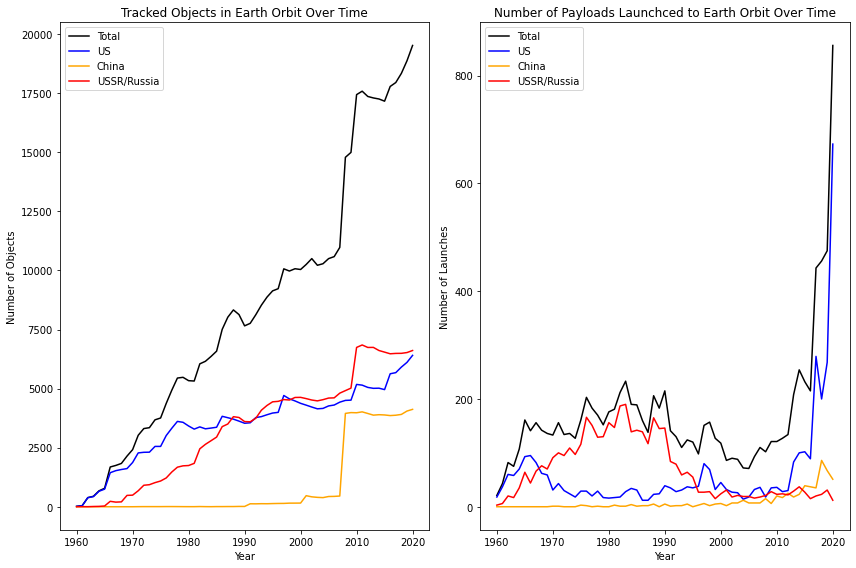

In [ ]:
### PLOTTING N_OBJECTS AND LAUNCHES OVER TIME
fig, axs = plt.subplots(1,2,figsize=(12,8))

# TOTAL NUMBER OF LOW-EARTH OBJECTS AND BY COUNTRY
axs[0].plot(year_range,debris_count,c="black", label="Total")
axs[0].plot(year_range,us_count,c="blue",label="US")
axs[0].plot(year_range,prc_count,c="orange",label="China")
axs[0].plot(year_range,cis_count,c="red",label="USSR/Russia")

axs[0].set(xlabel="Year",ylabel="Number of Objects",title="Tracked Objects in Earth Orbit Over Time")
axs[0].legend()

# TOTAL NUMBER OF LAUNCHES AND BY COUNTRY
axs[1].plot(year_range,n_payloads,c="black", label="Total")
axs[1].plot(year_range,us_payloads,c="blue",label="US")
axs[1].plot(year_range,prc_payloads,c="orange",label="China")
axs[1].plot(year_range,cis_payloads,c="red",label="USSR/Russia")
axs[1].set(xlabel="Year",ylabel="Number of Launches",title="Number of Payloads Launchced to Earth Orbit Over Time")
axs[1].legend()

plt.tight_layout()
#plt.savefig("nobjects_and_nlaunches_over_time.png")

Text(0, 0.5, 'Number of Fragmentation Events')

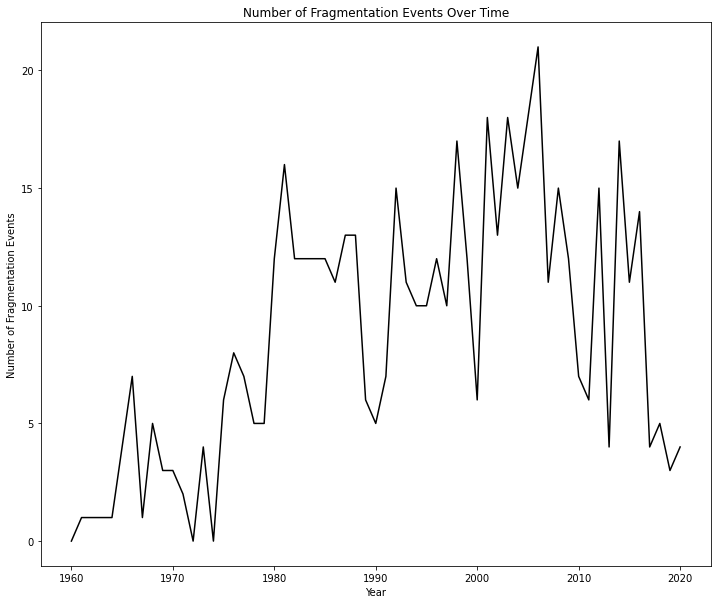

In [ ]:
### FINDING AND PLOTTING NUMBER OF FRAGMENTATION EVENTS OVER TIME

# FIND NUMBER OF FRAGMENTATION EVENTS BY YEAR
frag_events = pd.Series([0,0,0],index=[1960,1972,1974]).append(frag['EYear'].value_counts()).sort_index()


# PLOT FRAGMENTATION EVENTS OVER TIME
fig, ax = plt.subplots(figsize = (12,10))
plt.plot(year_range, frag_events,color='k')
plt.title("Number of Fragmentation Events Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Fragmentation Events")

# plt.savefig('fragmentations_over_time.png')


[Text(0.5, 1.0, 'Total Catalogued Object Produced Through Fragmentation Events'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Total Objects Produced')]

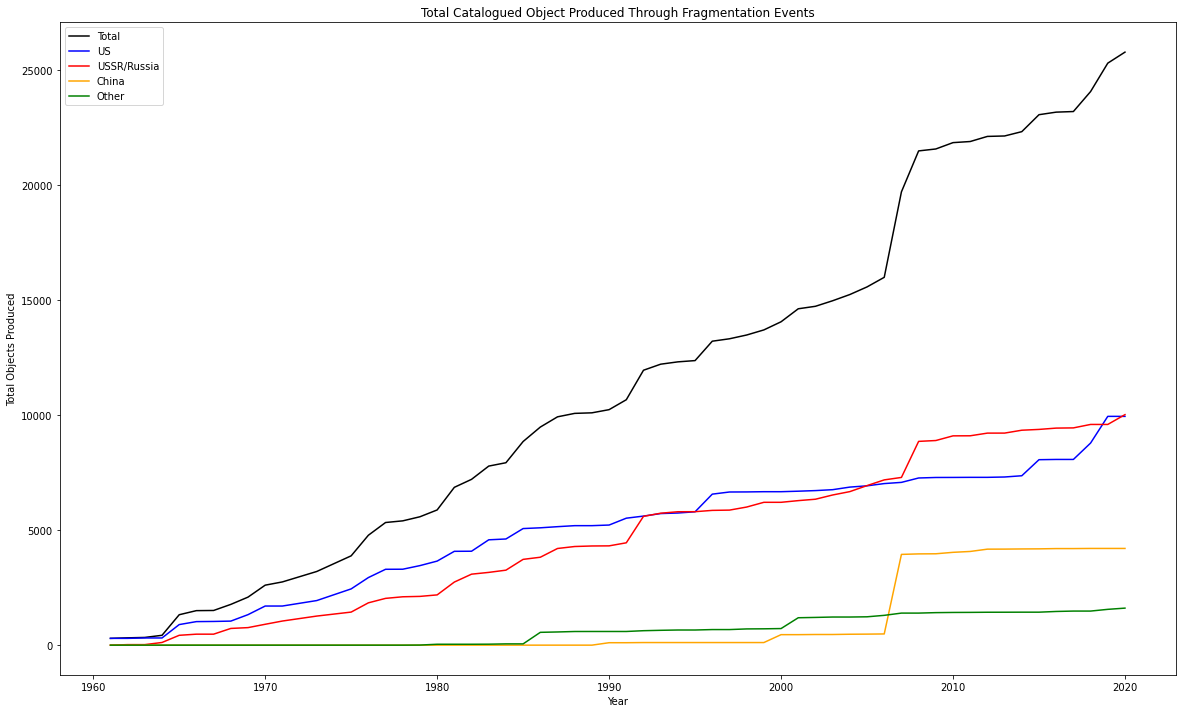

In [ ]:
###  NUMBER OF DEBRIS OBJECTS PRODUCED BY FRAGMENTATION EVENTS
###  TOTAL AND BY COUNTRY

# FIND NUMBER OF DEBRIS OBJECTS PRODUCED BY COUNTRY 
russia, china, us, other = [], [], [], []

for year in years:
    russia.append(np.sum(frag[(frag["COUNTRY"]=="CIS") & (frag['EYear'] <= year)]['Catalogued Objects']))
    china.append(np.sum(frag[(frag["COUNTRY"]=="PRC") & (frag['EYear'] <= year)]['Catalogued Objects']))
    us.append(np.sum(frag[(frag["COUNTRY"]=="US") & (frag['EYear'] <= year)]['Catalogued Objects']))
    other.append(np.sum(frag[(frag["COUNTRY"]!="US") & (frag["COUNTRY"]!="CIS") & (frag["COUNTRY"]!="PRC") & (frag['EYear'] <= year)]['Catalogued Objects']))

total = np.array([russia,china,us,other]).sum(axis=0)

# PLOT NUMBER OF DEBRIS OBJECTS PRODUCED BY COUNTRY
fig, ax = plt.subplots(1,1,figsize=(20,12))
ax.plot(years, total, label = 'Total',c='black')
ax.plot(years, us, label = 'US',c='blue')
ax.plot(years, russia, label = 'USSR/Russia',c='red')
ax.plot(years, china, label = 'China',c='orange')
ax.plot(years, other, label = 'Other',c='green')
ax.legend()
ax.set(title='Total Catalogued Object Produced Through Fragmentation Events',xlabel='Year',ylabel='Total Objects Produced')

# plt.savefig('objects_vs_country_vs_time.png')

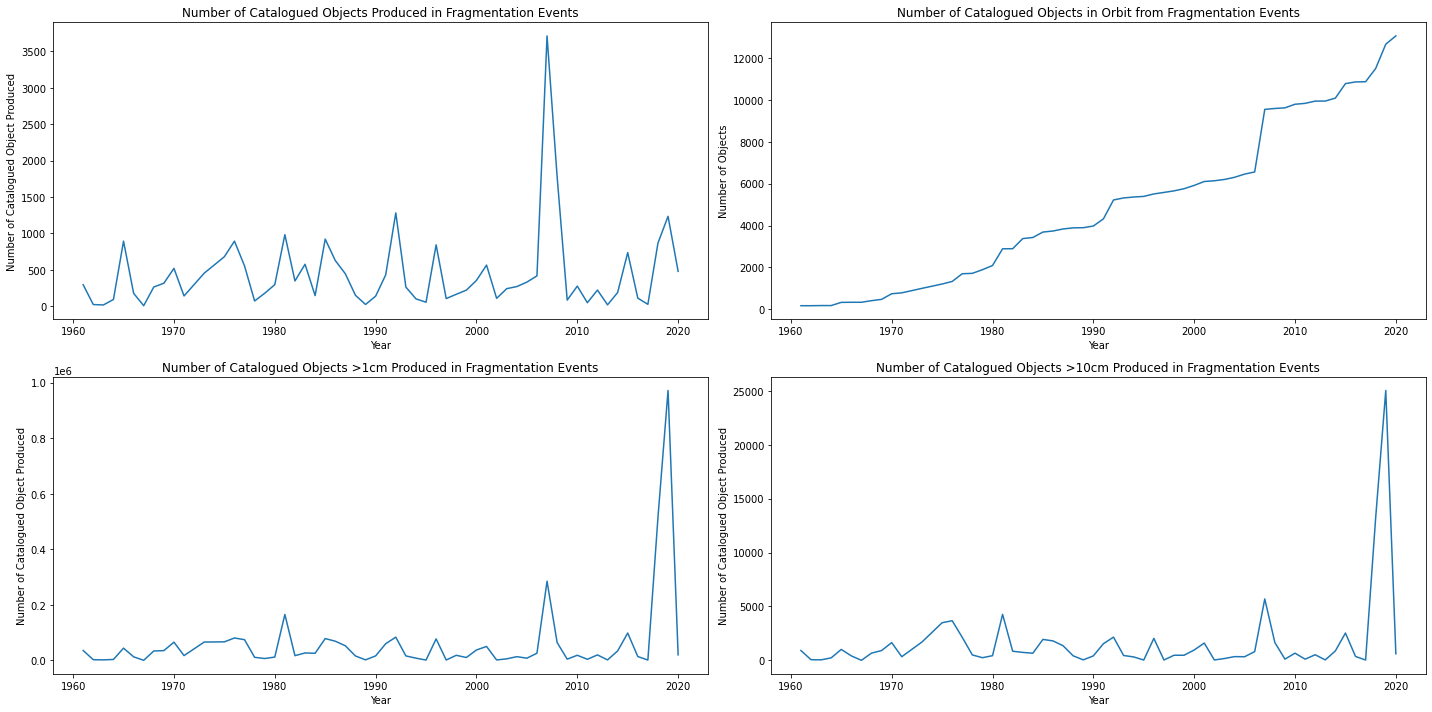

In [ ]:
years = np.array(num_events.index)
num = np.array(num_events['Name_x'])
sum_cat = np.array(frag.groupby('EYear').sum()['Catalogued Objects'])
sum_1cm = np.array(frag.groupby('EYear').sum()['Objects > 1 cm'])
sum_10cm = np.array(frag.groupby('EYear').sum()['Objects > 10 cm'])
sum_orbit = np.array(frag.groupby('EYear').sum()['Objects on Orbit'])
tot_orbit = []
c = 0
for i in range(len(years)):
    c+=sum_orbit[i]
    tot_orbit.append(c)

fig, ax = plt.subplots(2, 2, figsize = (20,10))
ax[0][0].plot(years, sum_cat)
ax[0][0].set_title("Number of Catalogued Objects Produced in Fragmentation Events")
ax[0][0].set_xlabel("Year")
ax[0][0].set_ylabel("Number of Catalogued Object Produced")
ax[0][1].plot(years, tot_orbit)
ax[0][1].set_title("Number of Catalogued Objects in Orbit from Fragmentation Events")
ax[0][1].set_xlabel("Year")
ax[0][1].set_ylabel("Number of Objects")
ax[1][0].plot(years, sum_1cm)
ax[1][0].set_title("Number of Catalogued Objects >1cm Produced in Fragmentation Events")
ax[1][0].set_xlabel("Year")
ax[1][0].set_ylabel("Number of Catalogued Object Produced")
ax[1][1].plot(years, sum_10cm)
ax[1][1].set_title("Number of Catalogued Objects >10cm Produced in Fragmentation Events")
ax[1][1].set_xlabel("Year")
ax[1][1].set_ylabel("Number of Catalogued Object Produced")

plt.tight_layout()

#plt.savefig('num_objects.png')

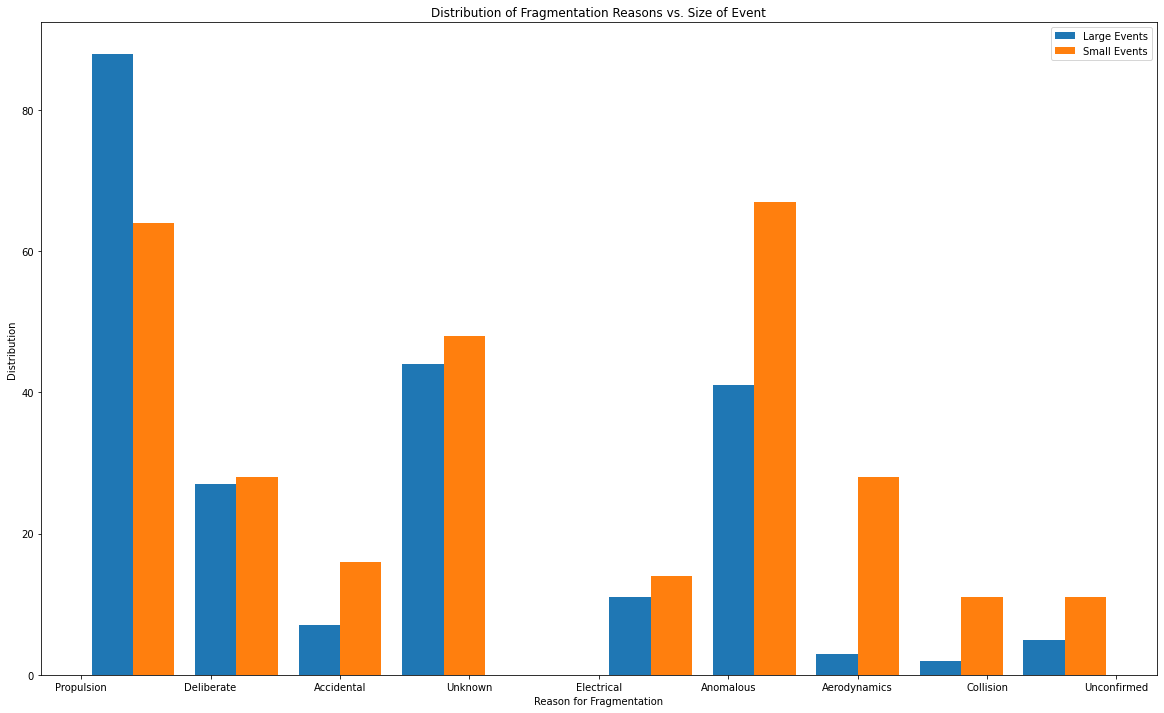

In [ ]:
### REASONS FOR FRAGMENTATION BY EVENT SIZE

# CLASSIFY FRAGMENTATION EVENTS BY NUMBER OF DEBRIS OBJECTS PRODUCED
large_events = frag[frag['Catalogued Objects'] > 10]
small_events = frag[frag['Catalogued Objects'] < 10]

# BAR PLOT OF DIFFERENT FRAGMENTATION EVENTS BY REASON 
fig, ax = plt.subplots(1,1,figsize=(20,12))
ax.hist([large_events['Event Type'], small_events['Event Type']], label = ['Large Events', 'Small Events'])
ax.set(title="Distribution of Fragmentation Reasons vs. Size of Event",xlabel="Reason for Fragmentation",ylabel="Distribution")
ax.legend()

# plt.savefig('event_dist.png')

SECTION 3: TIME-SERIES MODELING 

Section 3.A. Baseline Model

In [ ]:
### CREATE DATAFRAME FOR NUMBER OF PAYLOADS PER YEAR
d = {'years': year_range, 'target': n_payloads}
dataframe = pd.DataFrame(data=d)
warnings.filterwarnings('ignore')


The expected error in our predictions on the baseline mode is  8975.889674082395


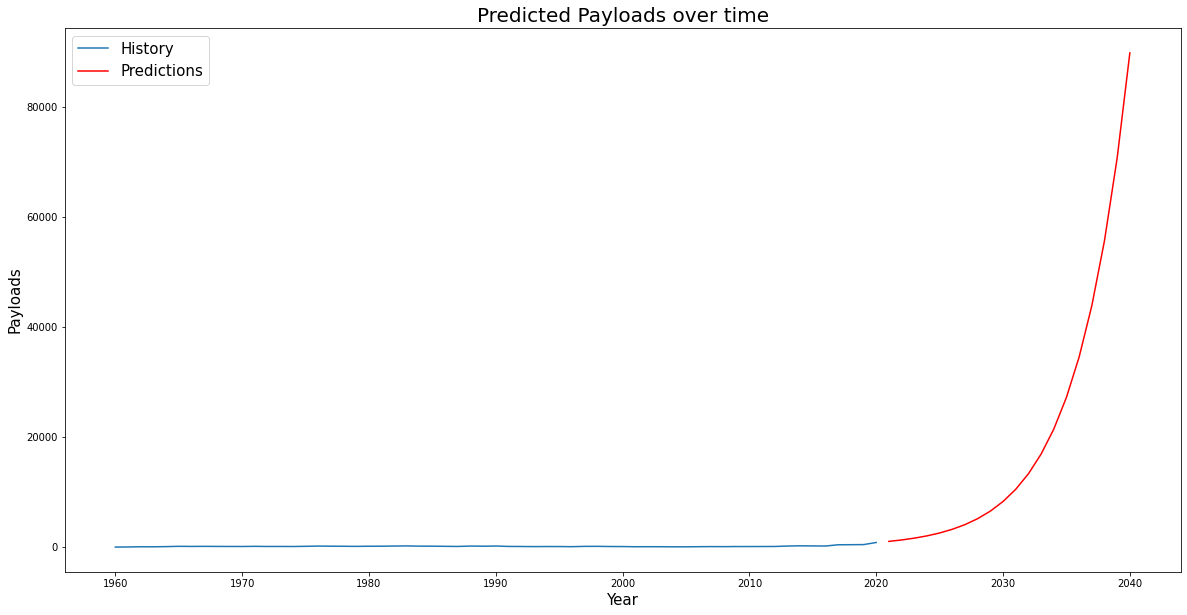

In [ ]:
# BASELINE GENERIC AUTOREGRESSION

train = dataframe[(dataframe['years'] >= 1960) & (dataframe['years'] < 2005)]
test = dataframe[dataframe['years'] >= 2005]   

baseline_model = AutoReg(dataframe['target'], lags=1)
model_fit = baseline_model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

error_exp = mean_squared_error(test['target'], predictions)

baseline_model_p = AutoReg(dataframe['target'], lags=1)
model_fit = baseline_model_p.fit()
preds = model_fit.predict(start=len(dataframe), end=len(dataframe)+19, dynamic=False)

print("The expected error in our predictions on the baseline mode is ", error_exp)

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(year_range,n_payloads, label='History')
ax.plot(range(2021,2041), preds, color='red', label="Predictions")
#ax.fill_between(range(2021,2041),with_interval_minus, with_interval_plus, color='b', alpha=.1, label='95% Prediction Interval')
ax.set_xlabel("Year", size=15)
ax.set_title("Predicted Payloads over time", size=20)
ax.set_ylabel("Payloads", size=15)
ax.legend(loc="upper left", prop={'size':15})
plt.show()



Section 3.B. Time-Series Model for Number of Payloads Launched per Year

In [ ]:
# GENERIC AUTOREGRESSION
# FUNCTION

def tuning(data): 
    errors = []
    bests = []
    for i in range(2, 6):
        year_end = int(i*10 + 1960)
        train_val = data[(data['years'] >= 1960) & (data['years'] < year_end)]
        test = data[(data['years'] >= year_end) & (data['years'] < (year_end+10))]    

        mse = []
        # conduct 5 fold cross validation to find optimal lag
        for j in range(1,5):
            folds = []
            for h in range(0, int((year_end-1970)/5)):
                end = int(1970 + h*5)
                train = train_val[(train_val['years'] >= 1960) & (train_val['years'] < end)]
                val = train_val[(train_val['years'] >= end) & (train_val['years'] < (end+5))]

                # fit model
                model = AutoReg(train['target'], lags=j)
                model_fit = model.fit()

                # in model optimization
                predictions = model_fit.predict(start=len(train), end=len(train)+len(val)-1, dynamic=False)
                folds.append(mean_squared_error(val['target'], predictions))
            mse.append(statistics.mean(folds))

        best = mse.index(min(mse)) +1 
        bests.append(best)
        model = AutoReg(train_val['target'], lags=best)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_val), end=len(train_val)+len(test)-1, dynamic=False)
        errors.append(mean_squared_error(test['target'], predictions))

    best = max(set(bests), key=bests.count) 
    expected_error = statistics.mean(errors) 

    final_model = AutoReg(data['target'], lags=best)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(data), end=len(data)+19, dynamic=False)

    return [predictions, expected_error, best]


In [ ]:
# BOOTSTRAP TO MAKE PREDICTION INTERVAL
def bootstrap(dataframe):
    predictions = {}
    values = []
    keys = range(20)

    for i in range(30):
        data = dataframe.copy()
        x = data['target'].tolist()

        replace = []
        for i in range(1,len(x)):
            replace.append(x[i] - x[i-1])
        #data = data.sample(frac=1, replace=True)

        series = pd.Series(replace)
        series = series.sample(frac=1, replace=True).tolist()


        boots = []
        start = x[0]
        boots.append(start)


        for i in range(0, len(replace)):
            start = start + series[i]
            boots.append(start)

        data['target'] = boots #data.sort_values(by=['years'], axis=0)
        returned = tuning(data)[0].tolist()
        err = tuning(data)[1]

        name = "Bootstrap " + str(i)
        values.append(returned)
        
        #predictions[name] = tuning(data)

    for key in keys:
        predictions[key] = values[key]

    predict_df = pd.DataFrame(data=predictions)

    stds = predict_df.std(axis=1).tolist()

    with_interval_plus = [j+(1.96 * stds[i]*math.sqrt(1.5)) for i,j in enumerate(base_predict)]
    with_interval_minus = [j-(1.96 * stds[i]*math.sqrt(1.5)) for i,j in enumerate(base_predict)]

    return [with_interval_minus, with_interval_plus]


In [ ]:
# ARIMA MODEL
def arima(dataframe):
	p_potential = range(1,5)
	d_potential = range(3)
	q_potential = range(2)

	# optimize parameters 
	for p in p_potential:
		for d in d_potential:
			for q in q_potential:

				train = dataframe[(dataframe['years'] >= 1960) & (dataframe['years'] < 2005)]['target'].tolist()
				test = dataframe[(dataframe['years'] >= 2005)]['target'].tolist()

				history = [x for x in train]
				predictions, errors  = [], []

				for t in range(len(test)):
					model = ARIMA(history, order=(p,d,q))
					model_fit = model.fit()
					output = model_fit.forecast()
					# output.predicted_mean
					# output.se_mean
					yhat = output[0]
					predictions.append(yhat)
					obs = test[t]
					history.append(obs)
					#print('predicted=%f, expected=%f' % (yhat, obs))
				# evaluate forecasts
				mse = mean_squared_error(test, predictions)
				iteration = [p,d,q,mse]
				errors.append(iteration)

	minimum = [0,errors[0][3]]
	for i in errors:
		if i[3] < minimum[1]:
			minimum = [i,i[3]]

	best_p = errors[minimum[0]][0]
	best_d = errors[minimum[0]][1]
	best_q = errors[minimum[0]][2]
	mse = errors[minimum[0]][3]
				
	train = dataframe['target'].tolist()

	history = [x for x in train]
	predictions = []

	for t in range(20):
		model = ARIMA(history, order=(best_p,best_d,best_q))
		model_fit = model.fit()
		output = model_fit.forecast()
					# output.predicted_mean
					# output.se_mean
		yhat = output[0]
		predictions.append(yhat)
		#obs = test[t]
		history.append(yhat)

	return [predictions, best_p, best_d, best_q, mse]



The expected error of the model's estimations is  10119.9846
The optimal lag parameter is  4


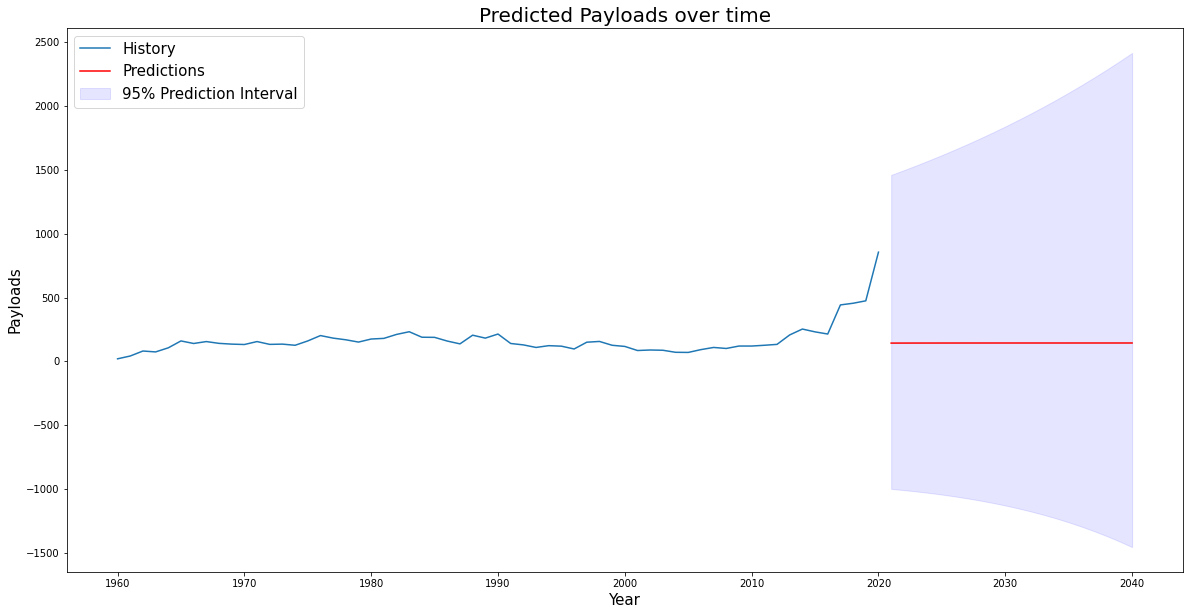

In [ ]:
### GENERAL AUTO-REGRESSIVE MODEL 

# FIT GENERAL AUTO-REGRESSIVE MODEL
res = tuning(dataframe)

base_predict = res[0].tolist()
expected_error = res[1]
best = res[2]

print("The expected error of the model's estimations is ", round(expected_error, 4))
print("The optimal lag parameter is ", best)

# PLOT GENERAL AUTO-REGRESSIVE MODEL PREDICTIONS WITH PREDICTION INTERVALS 
with_interval_minus = bootstrap(dataframe)[0]
with_interval_plus = bootstrap(dataframe)[1]

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(year_range,n_payloads, label='History')
ax.plot(range(2021,2041), base_predict, color='red', label="Predictions")
ax.fill_between(range(2021,2041),with_interval_minus, with_interval_plus, color='b', alpha=.1, label='95% Prediction Interval')
ax.set_xlabel("Year", size=15)
ax.set_title("Predicted Payloads over time", size=20)
ax.set_ylabel("Payloads", size=15)
ax.legend(loc="upper left", prop={'size':15})
plt.show()

Test MSE: 11921.555
The best lag value is 4
The best degree of differencing is 2
The best order of moving average is 1


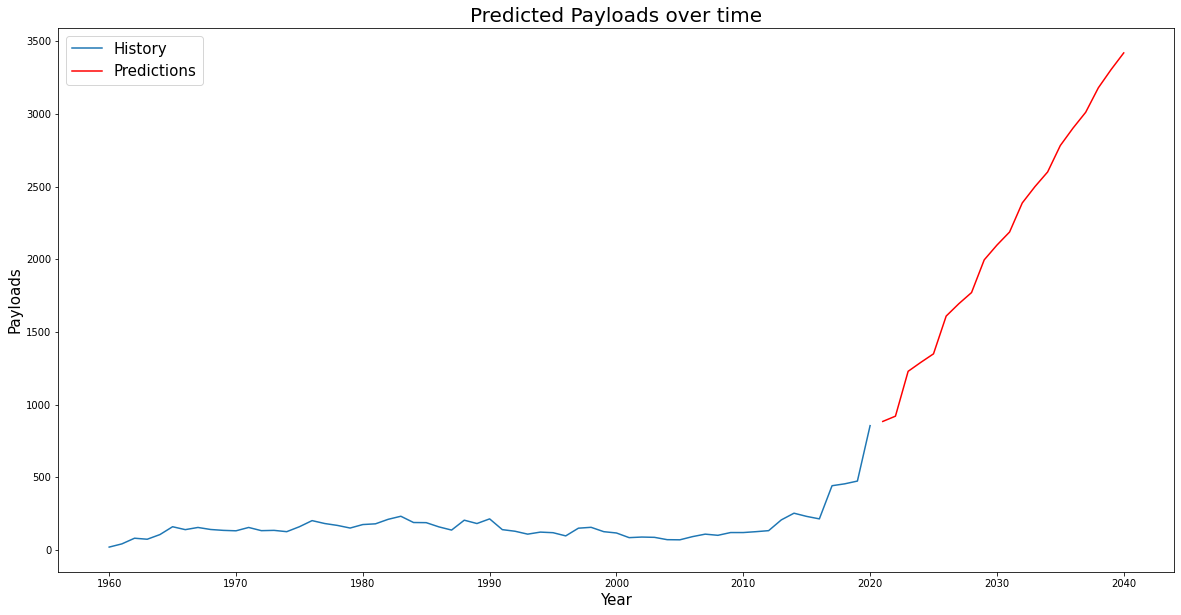

In [ ]:
### ARIMA MODEL 

# FIT ARIMA MODEL
results = arima(dataframe)
predicted_payloads = results[0]

print('Test MSE: %.3f' % results[4])
print("The best lag value is", results[1])
print("The best degree of differencing is", results[2])
print("The best order of moving average is", results[3])

# PLOT ARIMA MODEL PREDICTIONS WITH PREDICTION INTERVALS 
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(year_range,n_payloads, label='History')
ax.plot(range(2021,2041), results[0], color='red', label="Predictions")
#ax.fill_between(range(2021,2041),with_interval_minus, with_interval_plus, color='b', alpha=.1, label='95% Prediction Interval')
ax.set_xlabel("Year", size=15)
ax.set_title("Predicted Payloads over time", size=20)
ax.set_ylabel("Payloads", size=15)
ax.legend(loc="upper left", prop={'size':15})
plt.show()

Section 3.C. Time-Series Model for Fragmentation Events per Year

In [ ]:
### CREATE DATAFRAME FOR FRAGMENTAITON EVENTS PER YEAR
d = {'years': year_range, 'target': frag_events}
dataframe = pd.DataFrame(data=d)
warnings.filterwarnings('ignore')


The expected error of the model's estimations is  41.0165


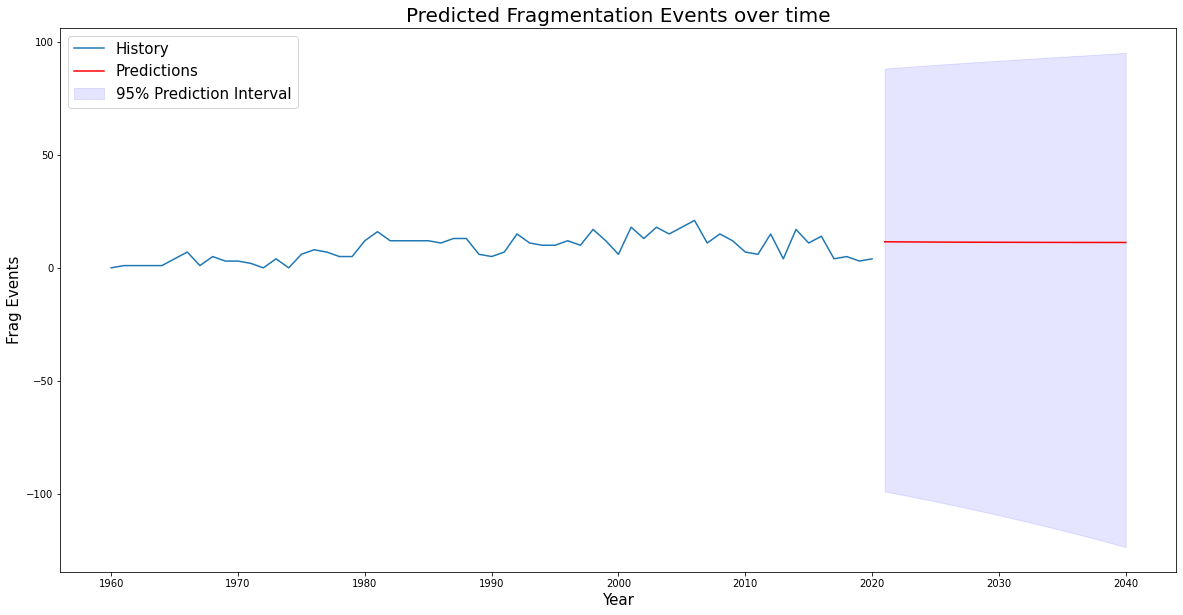

In [ ]:
### GENERAL AUTO-REGRESSIVE MODEL 

# FIT GENERAL AUTO-REGRESSIVE MODEL
base_predict = tuning(dataframe)[0].tolist()
frag_predictions = base_predict
expected_error = tuning(dataframe)[1]

print("The expected error of the model's estimations is ", round(expected_error, 4))

# PLOT GENERAL AUTO-REGRESSIVE MODEL PREDICTIONS WITH PREDICTION INTERVALS 
with_interval_minus = bootstrap(dataframe)[0]
with_interval_plus = bootstrap(dataframe)[1]

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(year_range,frag_events, label='History')
ax.plot(range(2021,2041), base_predict, color='red', label="Predictions")
ax.fill_between(range(2021,2041),with_interval_minus, with_interval_plus, color='b', alpha=.1, label='95% Prediction Interval')
ax.set_xlabel("Year", size=15)
ax.set_title("Predicted Fragmentation Events over time", size=20)
ax.set_ylabel("Frag Events", size=15)
ax.legend(loc="upper left", prop={'size':15})
plt.show()

Test MSE: 37.227
The best lag value is 4
The best degree of differencing is 2
The best order of moving average is 1


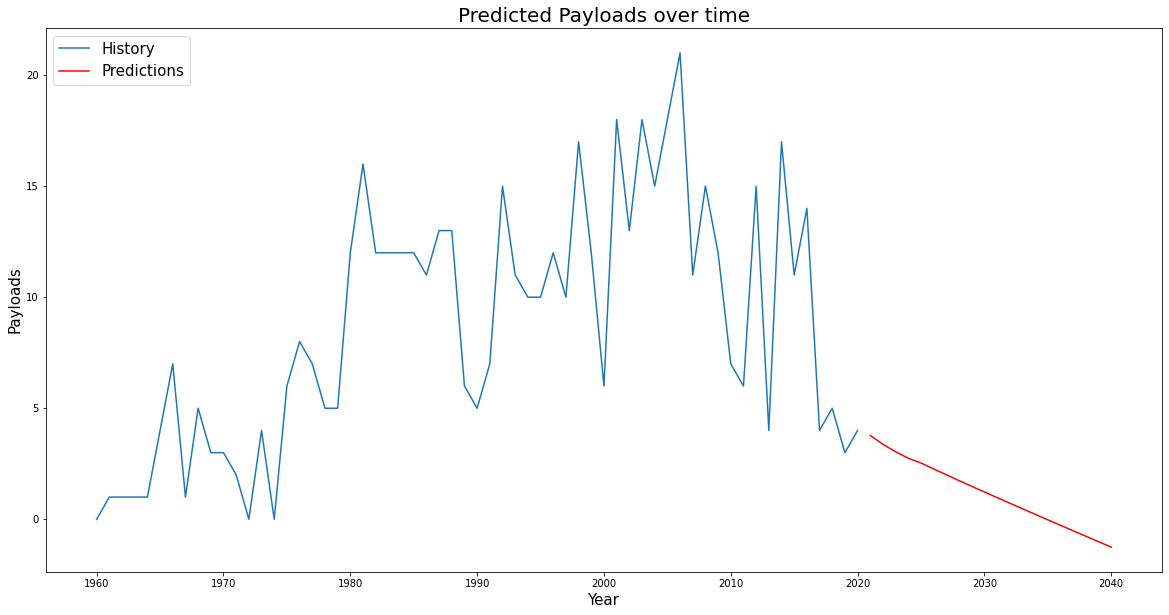

In [ ]:
### ARIMA MODEL 

# FIT ARIMA MODEL 
results = arima(dataframe)

print('Test MSE: %.3f' % results[4])
print("The best lag value is", results[1])
print("The best degree of differencing is", results[2])
print("The best order of moving average is", results[3])

### PLOT ARIMA MODEL PREDICTIONS WITH PREDICTION INTERVALS 
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(year_range,frag_events, label='History')
ax.plot(range(2021,2041), results[0], color='red', label="Predictions")
#ax.fill_between(range(2021,2041),with_interval_minus, with_interval_plus, color='b', alpha=.1, label='95% Prediction Interval')
ax.set_xlabel("Year", size=15)
ax.set_title("Predicted Payloads over time", size=20)
ax.set_ylabel("Payloads", size=15)
ax.legend(loc="upper left", prop={'size':15})
plt.show()

Section 3.D. Comparing Debris Generation from Payload Launches with Fragmentation Events

In [ ]:
### MEDIAN NUMBER OF DEBRIS OBJECTS PRODUCED BY 
### A) PAYLOAD LAUNCHES
### B) FRAGMENTATION EVENTS

# MEDIAN NUMBER OF TOTAL OBJECTS AFTER PAYLOAD LAUNCH
# total number of payload+component objects / total number of payloads
# component objects are objects that were meant to be separated from main system 
nobjs = debris_objects[(debris_objects['Type'].str[0]=='P')|(debris_objects['Type'].str[0]=='C')].shape[0]
npayloads = debris_objects[(debris_objects['Type'].str[0]=='P')].shape[0]
nobjs_payload = nobjs / npayloads

# MEDIAN NUMBER OF TOTAL OBJECTS AFTER FRAGMENTATION EVENT 
nobjs_collision = np.median(frag["Catalogued Objects"])

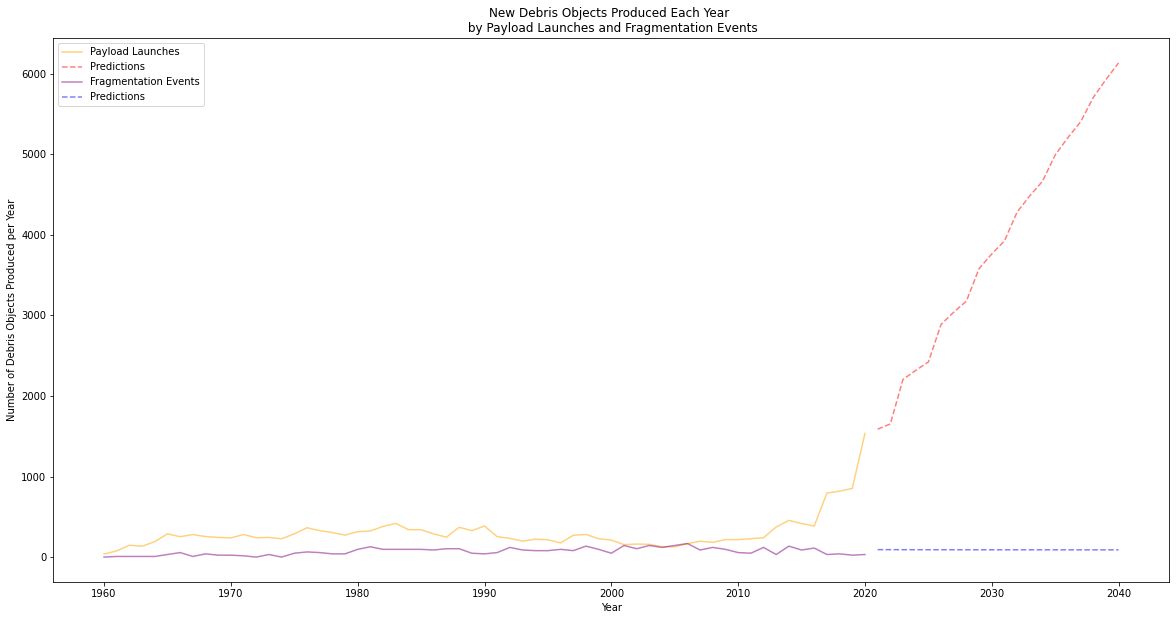

In [ ]:
### PLOT PREDICTED NUMBER OF DEBRIS OBJECTS PRODUCED OVER TIME BY 

fig, ax = plt.subplots(1,1, figsize=(20,10))
# A) PAYLOAD LAUNCHES
ax.plot(year_range,np.array(n_payloads)*nobjs_payload,color='orange',alpha=0.5,label='Payload Launches')
ax.plot(range(2021,2041), np.array(predicted_payloads)*nobjs_payload, linestyle='--', color='red', label="Predictions",alpha=0.5)
# B) FRAGMENTATION EVENTS
ax.plot(year_range,np.array(frag_events)*nobjs_collision, label='Fragmentation Events',color='purple',alpha=0.5)
ax.plot(range(2021,2041), np.array(frag_predictions)*nobjs_collision, color='blue', label="Predictions",alpha=0.5,linestyle='--')

ax.set(xlabel='Year',ylabel='Number of Debris Objects Produced per Year',title='New Debris Objects Produced Each Year \n by Payload Launches and Fragmentation Events')
ax.legend()


SECTION 4: CLASSIFICATION MODELING 

Section 4.A. Random Forest Models to Classify Satellites by Potential Contribution to Future Space Debris   

In [ ]:
# fragmentation baseline
baseline = []
for i in range(len(y_frag_test_2)):
    baseline.append(0)

baseline_probability = y_frag_train_2[y_frag_train_2 == 1].shape[0]/y_frag_train_2.shape[0]
baseline_accuracy = accuracy_score(y_frag_test_2, baseline)

print("Fragmentation baseline probability: {:0.4f}".format(baseline_probability))
print("Fragmentation Baseline Accuracy: {:0.4f}".format(baseline_accuracy))

In [ ]:
# Data wrangling for modeling
predictors_frag = ['COUNTRY', 'Mass', 'Length', 'Diameter', 'Span', 'Shape', 'OpOrbit', 'Event Type', 'Apogee', 'Perigee','Inc', 'Catalogued Objects']

frag_pred = frag[predictors_frag]
frag_pred['Catalogued Objects'] = frag_pred['Catalogued Objects'].fillna(0)
frag_pred['large_event'] = (frag_pred['Catalogued Objects'] > 10)*1.0
frag_pred['Shape'] = frag_pred['Shapefillna('unknown')
frag_pred = frag_pred.dropna(subset =['Apogee'])
frag_pred = frag_pred.drop('Catalogued Objects', axis = 1)
frag_pred = pd.get_dummies(frag_pred, columns = ['COUNTRY', 'Shape', 'Event Type', 'OpOrbit'] )
frag_train, frag_test = train_test_split(frag_pred, train_size=0.8, random_state=111)
predictors_to_scale = ['Mass', 'Length', 'Diameter', 'Span', 'Apogee', 'Perigee' ]
scaler = StandardScaler().fit(frag_train[predictors_to_scale])
frag_train[predictors_to_scale] = scaler.transform(frag_train[predictors_to_scale])
frag_test[predictors_to_scale] = scaler.transform(frag_test[predictors_to_scale])

x_frag_train = frag_train.drop('large_event', axis = 1)
y_frag_train_2 = frag_train['large_event']
x_frag_test = frag_test.drop('large_event', axis = 1)
# y_frag_test = frag_test['Catalogued Objects']
y_frag_test_2 = frag_test['large_event']

In [ ]:
# Random Forest: Tuning hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt', 'auto']
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_frag_train, y_frag_train_2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['log2', 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
best_params = rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 76,
 'bootstrap': False}

In [ ]:
param_grid_gs = {
    'bootstrap': [True],
    'max_depth': [ 20, 30,50,80,90, 100],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [2, 3, 7, 10, 13],
    'n_estimators': [200, 700, 900, 1000, 1100, 1500]
}

In [ ]:
# Create a based model
rf_2 = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_2, param_grid = param_grid_gs, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_frag_train, y_frag_train_2)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 45.4min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [20, 30, 50, 80, 90, 100],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 7, 10, 13],
                         'n_estimators': [200, 700, 900, 1000, 1100, 1500]},
             verbose=2)

In [ ]:
best_grid = grid_search.best_params_
best_grid

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 1500}

In [ ]:
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_frag_test)
y_pred_train = best_model.predict(x_frag_train)

test_acc = accuracy_score(y_frag_test_2, y_pred_test)
train_acc = accuracy_score(y_frag_train_2, y_pred_train )

print("Train Accuracy: {:0.4f}".format(train_acc))
print("Test Accuracy: {:0.4f}".format(test_acc))

Train Accuracy: 0.8629
Test Accuracy: 0.7358


Section 4.B. Neural Networks to Classify Satellites by Potential Contribution to Future Space Debris   

In [ ]:
# initialize NN model with 3 hidden layers and 2 drop out layers
large_event_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (99,)),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

In [ ]:
# use the adam optimizer and the appropriate metrics for binary classification
large_event_model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics = ['accuracy'])

# fit model with manually trained parameters
large_event_hist = large_event_model.fit(
    x = np.array(x_frag_train), y = np.array(y_frag_train_2), 
    epochs=50, batch_size=8, 
    validation_split = 0.3, 
    verbose = False
)

In [ ]:
# plot trian and validation accuracies to check overfitting
plt.figure(figsize=[12,4])
plt.plot(large_event_hist.history['accuracy'], label = 'Train Accuracy', linewidth=4)
plt.plot(large_event_hist.history['val_accuracy'], label = 'Validation Accuracy', linewidth=4, alpha=.7)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epoch of Overfit NN Model")L
plt.legend()

In [ ]:
# evaluate train and test accuracies
train_accuracy = large_event_model.evaluate(np.array(x_frag_train),np.array(y_frag_train_2), verbose = False)[1]
test_accuracy = large_event_model.evaluate(np.array(x_frag_test),np.array(y_frag_test_2), verbose = False)[1]
print("Train Accuracy: {:0.4f}".format(train_accuracy))
print("Test Accuracy: {:0.4f}".format(test_accuracy))

In [ ]:
# create proxy model to examine feature importance 
y_pred_train = ((large_event_model.predict(np.array(x_frag_train)) > 0.5)*1.0)
logreg = LogisticRegression(C = 10, penalty = 'l2', max_iter = 20000).fit(x_frag_train, y_pred_train.ravel())
print("Logistic Regression Accuracy: {:0.4f}".format(logreg.score(x_frag_test, y_frag_test_2)))


In [ ]:
importances = permutation_importance(logreg, x_frag_train, y_frag_train_2, n_jobs = -1)['importances_mean']

# plot the top 10 most important predictors as dictated by their relative importance
columns = x_frag_train.columns
importance_df = pd.DataFrame(list(zip(importances, columns)), columns = ['importance', 'feature'])

importance_df['relative_importance'] = importance_df['importance']/importances.max()

top = importance_df.sort_values(by = 'importance', ascending = False).head(10)

fig, ax = plt.subplots(1, 1, figsize = (12,10))
ax.barh(top['feature'],top['relative_importance'], align='center',color="blue",alpha=0.7)
ax.grid(linewidth=0.2)
ax.set_ylabel("Predictor")
ax.set_xlabel("Relative Importance")
ax.set_title("Relative Importances of Top 10 Most Important Predictors")

# plt.savefig('feature_importanc.png')

NameError: name 'permutation_importance' is not defined